In [1]:
using Random

# Produce synthetic emails that are 'spam' or 'not spam'

- Key words that belong to both groups of emails
- keywords for emails pertaining to spam
- keywords for words pertaining to work
- create a vector for all the words possible (corpus)

In [1]:
words_corpus = ["apple", "banana", "cat", "dog","car","the","is","a","hi","hello","ok","fine","great","best"]
intro_corpus = ["Dear","Greetings","Salutations"]
spam_keywords = ["sales","limited","exclusive","discount","opportunity","attention","immediate","bank"]
work_keywords = ["meeting","colleague","holiday","deliverable","office","accounting","board","bank"];
special_words = ["Florida","Orlando","UCF","statistics","Julia"]
all_words = unique( [words_corpus...,intro_corpus...,spam_keywords...,work_keywords...] );

## for a set of 'n' emails of length 'email_length', add an intro, then randomly select if the email will be spam or not-spam, within each conditional interleave the words with the normal words existing in both groups and words for one group or the other. 

In [2]:
email_length = 20

function generate_email(n)
    emails = []
    
    for _ in 1:n
        new_email = []
        
        intro_tmp = rand(intro_corpus,1)[1]
        push!(new_email,intro_tmp)
        push!(new_email," ")
        
        if rand() <= 0.5 #spam
            for _ in 1:email_length
                if rand() <= 0.5
                    word_tmp = rand(spam_keywords,1)[1]
                    push!(new_email,word_tmp)
                else
                    word_tmp = rand(words_corpus,1)[1]
                    push!(new_email,word_tmp)
                end
                push!(new_email," ")
            end
        else #non-spam
            for _ in 1:email_length
                if rand() <= 0.5
                    word_tmp = rand(work_keywords,1)[1]
                    push!(new_email,word_tmp)
                else
                    word_tmp = rand(words_corpus,1)[1]
                    push!(new_email,word_tmp)
                end
                push!(new_email," ")
            end
        end
        
        new_email = reduce(*,new_email)
        
        push!(emails,new_email)
    end
    
    return emails
end

generate_email (generic function with 1 method)

### produce an email with words that are not present in either spam or work emails (type of outlier)

In [4]:
email_outlier = map( x -> x * " " , [special_words...] ) |> x -> reduce(*,x)

"Florida Orlando UCF statistics Julia "

In [5]:
emails_fit = generate_email(200)
emails_new = generate_email(4)
insert!(emails_new,3, email_outlier)

5-element Vector{Any}:
 "Salutations apple accounting ca" ⋯ 75 bytes ⋯ "llo banana ok bank deliverable "
 "Dear fine limited the cat exclu" ⋯ 50 bytes ⋯ "on exclusive best limited a ok "
 "Florida Orlando UCF statistics Julia "
 "Salutations hello hello discoun" ⋯ 80 bytes ⋯ "scount immediate discount bank "
 "Salutations bank apple opportun" ⋯ 101 bytes ⋯ "ted a sales limited exclusive "

In [6]:
#import Pkg; 
#Pkg.add("JSON")
using JSON

In [8]:
emails_json = JSON.json(emails_fit)
emails_new_json = JSON.json(emails_new);

In [9]:
open("emails.json","w") do f 
    write(f, emails_json) 
end

open("emails_new.json","w") do f 
    write(f, emails_new_json) 
end

606

### read in that file and parse the JSON

In [11]:
emails_parsed = JSON.parsefile("emails.json")
emails_new_parsed = JSON.parsefile("emails_new.json")

5-element Vector{Any}:
 "Salutations apple accounting ca" ⋯ 75 bytes ⋯ "llo banana ok bank deliverable "
 "Dear fine limited the cat exclu" ⋯ 50 bytes ⋯ "on exclusive best limited a ok "
 "Florida Orlando UCF statistics Julia "
 "Salutations hello hello discoun" ⋯ 80 bytes ⋯ "scount immediate discount bank "
 "Salutations bank apple opportun" ⋯ 101 bytes ⋯ "ted a sales limited exclusive "

### get the corpus from the unique words present in all the emails

this line proceeds by 
- making a list of all the words by spreading the contents of the arrays into a new array having all the elements [emails_parsed...,emails_new_parsed...]
- concatenating all the words across all emails reduce(*,[emails_parsed...,emails_new_parsed...])
- split( reduce(*,[emails_parsed...,emails_new_parsed...])) splits all the words based on the defaul delimeter of the space
- then gets the unique array

In [12]:
all_seen_words = unique( split( reduce(*,[emails_parsed...,emails_new_parsed...])) );

## Create a word embedding vector for each email using the most simple approach

- Initialize a dictionary (key-value set) where the keys are all the possible words and the value is zero
- Go through each word in the email and add a count of observation to the word seen in the dictionary so that you have the total counts for each word 
- 'Normalize' the dictionary counts so that all the values sum to 1. This is important so that emails with more or less words are not affecting the 'relative' strength of words as a presence proportion in the email. Eg. an email with the word 'discount' in an email of 10 words should count the same as an email with 'discount' 10 times in an email of 100 words.
- return only the values of the dictionary. The values each time will have the same default order so that we can compare vectors on the relative presence of one keyword or another

You can consider it that each entry is a dimension produced by the amount of relative presence or absence of a potential key word

In [13]:
function email_to_vector(email)
    word_count = Dict(word => 0.0 for word in all_seen_words)
    
    for word in split(email)
        word_count[word] += 1
    end
    
    total_counts = sum( values(word_count) )
    normalized_vector = [word_count[word] / total_counts for word in all_seen_words]
    
    return normalized_vector
end

email_to_vector (generic function with 1 method)

In [14]:
sum( email_to_vector(emails_parsed[3]) )

1.0

In [15]:
#get the vectors for email sets
email_vectors = [email_to_vector(email) for email in emails_parsed];
email_new_vectors = [email_to_vector(email) for email in emails_new_parsed];

In [16]:
email_mat = hcat( email_vectors... );
email_new_mat = hcat( email_new_vectors... );

In [18]:
size(email_mat)

(37, 200)

In [19]:
using Statistics
using MultivariateStats
using Plots

## fit a PCA model to the matrix of emails (here this library assumes the dimensions run down the rows and the observations along the columns)

plot the eigenvalues

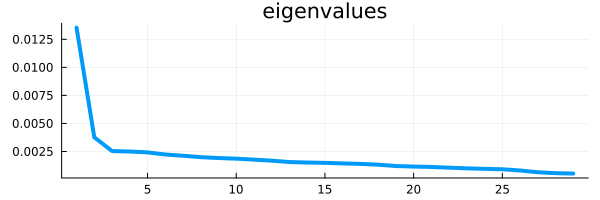

In [20]:
emails_pca_model_full = fit( PCA, email_mat; maxoutdim=size(email_mat,1) );
plot( emails_pca_model_full.prinvars, linewidth=4, title="eigenvalues", size=(600,200), legend=false )

### find the ratio of the total variance obtained from the 'first 2' and the 'first 3' eigenvalues

In [22]:
sum(emails_pca_model_full.prinvars[1:2]) / sum(emails_pca_model_full.prinvars)

0.30361811855971366

In [24]:
sum(emails_pca_model_full.prinvars[1:3]) / sum(emails_pca_model_full.prinvars)

0.34817664047812663

### this time select only up to 2 eigenvectors

In [25]:
emails_pca_model = fit(PCA, email_mat; maxoutdim=2);

## 'transform' the data (project the data onto the eigenvectors)

- this takes in the email vector representations, multiplies it agains the eigenvectors to get the 'transformations' which is the projection of the each email onto each eigenvector
- If there are 2 eigenvectors then each email is multiplied (projected) onto each vector producing a single value each time, and each value is considered to be a new 'x' and 'y'. If you had 5 eigenvectors, there would be 5 projections (multiplications) with a single email creating 5 values per email, but we choose 2 to make it easy to visualize.

In [26]:
emails_transformed = transform(emails_pca_model, email_mat)
emails_new_transformed = transform(emails_pca_model, email_new_mat)

2×5 Matrix{Float64}:
  0.0721453   -0.0820397   -0.00648536  -0.106034   -0.191232
 -0.00961795  -0.00415632   0.0191086   -0.0971514   0.00414779

get the max and min values for each eigenvector transformation to plot it

In [27]:
minimum_x = minimum( [emails_transformed[1,:]..., emails_new_transformed[1,:]...] ) - 0.1
maximum_x = maximum( [emails_transformed[1,:]..., emails_new_transformed[1,:]...] ) + 0.1

minimum_y = minimum( [emails_transformed[2,:]..., emails_new_transformed[2,:]...] ) - 0.1
maximum_y = maximum( [emails_transformed[2,:]..., emails_new_transformed[2,:]...] ) + 0.1

0.22765215914607095

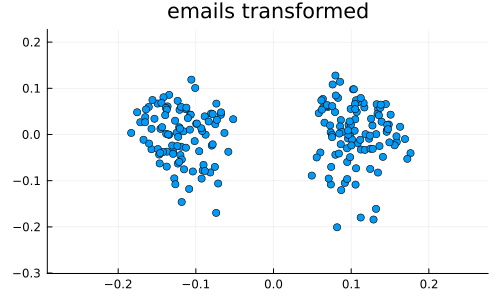

In [30]:
pt = plot( emails_transformed[1,:], emails_transformed[2,:], xlims=(minimum_x,maximum_x), ylims=(minimum_y,maximum_y),
        size=(500,300), title="emails transformed", seriestype=:scatter, legend=false )
display( pt )

### now plot the transformation of the new emails with number annotations

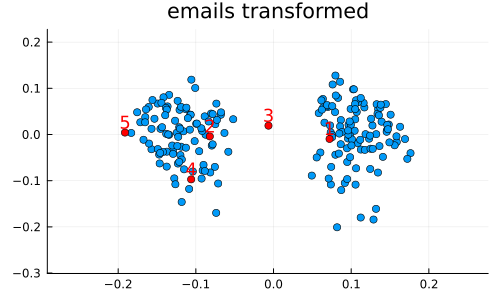

In [31]:
pt2 = plot( pt, emails_new_transformed[1,:], emails_new_transformed[2,:], size=(500,300), markercolor=:red, seriestype=:scatter )

for ind in 1:size(emails_new_transformed,2)
    annotate!(pt2, emails_new_transformed[1,ind], emails_new_transformed[2,ind], text(string(ind), :red, :bottom, 12) )
end

display(pt2)

## email 3 was our outlier and it does not reside within either cluster